In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cloudpickle as pickle
### Pytorch
import torch
import torch.nn as nn
from fastai.tabular import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
GLOBAL_SEED = 20210117
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(GLOBAL_SEED) 

# 1. Import data

In [3]:
[data_raw, protein_raw, activities_raw, 
 data_extend, protein_extend, activities_extend] = pickle.load(open('NR.pkl', 'rb'))
#mean, std = data_raw.mean(), data_raw.std() 

In [4]:
cont_names = data_raw.columns
cat_names = []
dep_var = 'Activity'
data_raw['Activity'] = [int(i<1) for i in activities_raw]
data_extend['Activity'] = [int(i<1) for i in activities_extend]
data_raw.shape, data_extend.shape
list(data_raw['Activity']).count(0), list(data_raw['Activity']).count(1)

((6554, 218), (713, 218))

(3129, 3425)

# 2. Split dataset

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=GLOBAL_SEED)
group_labels = np.array([i.split('_')[0]+'_'+str(data_raw.loc[i, 'Activity']) for i in data_raw.index])
for train_idx, valid_idx in sss.split(data_raw, group_labels):pass
data_train = data_raw.iloc[train_idx, :]
data_test = data_raw.iloc[valid_idx, :]

In [6]:
data_train.shape, data_test.shape, data_extend.shape

((3932, 218), (2622, 218), (713, 218))

# 3. Hyperparameter selection

In [11]:
def get_dl_AUC(data, train_idx, valid_idx, data_test, cont_names, dep_var, layern=2, celln=100, ps=0.5):
    procs = []
    data_tabular = (TabularList.from_df(data, cat_names=[], cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=valid_idx)
                           .label_from_df(cols=dep_var)
                           .add_test(TabularList.from_df(data_test, cat_names=[], cont_names=cont_names, procs=procs))
                           .databunch())
    learn = tabular_learner(data_tabular, layers=[celln for i in range(layern)], metrics=accuracy, ps=ps, silent=True)
    _ = learn.fit_one_cycle(50)
    ###
    preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
    _, pred_class = preds.max(1)
    pred_prob = preds[:, 1]
    valid_auc = roc_auc_score(data.iloc[valid_idx, :]['Activity'], pred_prob)
    ###
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    _, pred_class = preds.max(1)
    pred_prob = preds[:, 1]
    test_auc = roc_auc_score(data_test['Activity'], pred_prob)
    return valid_auc, test_auc

In [8]:
sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
group_labels = np.array([i.split('_')[0]+'_'+str(data_train.loc[i, 'Activity']) for i in data_train.index])
folds = list(sss.split(data_train, group_labels))

In [24]:
#result = pd.read_csv('Rawdata_DL_Parameters.csv', index_col=0)
#result = [list(i) for i in result.values]

In [25]:
result = []
#for layern in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
for layern in [6, 7, 8, 9, 10]:
    for celln in [100, 300, 500]:
        for ps in [0, 0.1, 0.3, 0.5]:
            #train_aucs = []
            valid_aucs = []
            test_aucs = []
            for fold in range(5):
                train_idx, valid_idx = folds[fold]
                valid_auc, test_auc = get_dl_AUC(data_train, train_idx, valid_idx, data_test, cont_names, 
                                                            dep_var, layern, celln, ps)
                result.append([fold, layern, celln, ps, valid_auc, test_auc])
                #train_aucs.append(train_auc)
                valid_aucs.append(valid_auc)
                test_aucs.append(test_auc)
            result.append(['Mean', layern, celln, ps, 
                           np.array(valid_aucs).mean(), np.array(test_aucs).mean()])
            print(layern, celln, ps, np.array(valid_aucs).mean(), np.array(test_aucs).mean())
result = pd.DataFrame(result, columns=['Fold', 'Layer', 'Cell', 'PS', 'Valid_AUC', 'Test_AUC'])
result.to_csv('Rawdata_DL_Parameters.csv')

1 100 0 0.8638127286409076 0.8515414752454469


1 100 0.1 0.8661946109777297 0.851340920221077


1 100 0.3 0.8683407193771169 0.8510000932814066


1 100 0.5 0.8599471204449525 0.8469896924045613


1 300 0 0.8654649704352948 0.857905540915557


1 300 0.1 0.8635430845614689 0.8521318299479956


1 300 0.3 0.8667666362613691 0.8520416967887876


1 300 0.5 0.8653916771186424 0.8491601758354517


KeyboardInterrupt: 

In [26]:
result = pd.read_csv('Rawdata_DL_Parameters.csv', index_col=0)
result.loc[result['Fold']=='Mean', :].sort_values('Valid_AUC', ascending=False).head(2)

,Fold,Layer,Cell,PS,Valid_AUC,Test_AUC
335,Mean,5,300,0.5,0.870694,0.853517
83,Mean,2,100,0.1,0.870680,0.855526


# 4. Oversampling prevents over fitting

In [28]:
def oversampling(data_train, N=3000, sigma=0.1, test_size=0.4):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0) #random_state=0
    protein_train = np.array([i.split('_')[0] for i in data_train.index])
    for train_idx, valid_idx in sss.split(data_train, protein_train):pass
    # sampling
    sample_data = []
    sample_label = []
    sample_proteins = []
    proteins = np.array([i.split('_')[0] for i in data_train.iloc[train_idx, :].index])
    for p in set(proteins):
        temp = data_train.iloc[train_idx, :].loc[proteins==p, :]
        if N-sum(proteins==p)<=0:
            continue
        for i in range(N-sum(proteins==p)):
            rrow = list(temp.iloc[random.choice(range(len(temp.index))), :])
            sample_data.append(rrow)
            sample_label.append(int(rrow[-1]))
            sample_proteins.append(p)
    if len(sample_label) == 0:
        return data_train, train_idx, valid_idx
    sample_data = pd.DataFrame(norm.rvs(np.array(sample_data), scale=sigma), columns=data_train.columns)
    sample_data.index = [sample_proteins[i]+'_OS_'+str(i) for i in range(len(sample_proteins))]
    sample_data[dep_var] = sample_label
    os_data = pd.DataFrame(data_train)
    os_data = os_data.append(sample_data)
    os_train_idx = list(set(range(len(os_data.index)))-set(valid_idx))
    return os_data, os_train_idx, valid_idx

def oversampling_dl_AUC(data, data_test, cont_names, dep_var, N, sigma, test_size=0.2, layern=2, celln=100, ps=0.5):
    os_data, train_idx, valid_idx = oversampling(data, N, sigma, test_size)
    train_auc, test_auc = get_dl_AUC(os_data, train_idx, valid_idx, data_test, cont_names, dep_var, layern, celln, ps)
    return train_auc, test_auc

def oversamping_dl_result(data, data_test, cont_names, dep_var, layern=2, celln=100, ps=0.5):
    result = []
    sigma = 0.1
    test_size = np.arange(0.1, 0.51, 0.05)
    N = np.arange(1000, 5001, 500)
    test_size, N = np.meshgrid(test_size, N)
    train_aucs = np.zeros(N.shape)
    test_aucs = np.zeros(N.shape)
    for i in range(N.shape[0]):
        for j in range(N.shape[1]):
            train_auc, test_auc = oversampling_dl_AUC(data, data_test, cont_names, dep_var, N[i][j], sigma, test_size[i][j], layern, celln, ps)
            train_aucs[i][j] = train_auc
            test_aucs[i][j] = test_auc
            print(N[i][j], round(1-test_size[i][j], 2), round(train_auc, 3), round(test_auc, 3))
            result.append([N[i][j], round(1-test_size[i][j], 2), train_auc, test_auc])
    result = pd.DataFrame(result, columns=['N', 'Train size', 'Test AUC', 'Extend AUC'])
    return N, (1-test_size), train_aucs, test_aucs, result

In [29]:
layern=5; celln=300; ps=0.5
N, train_size, test_aucs, extend_aucs, result = oversamping_dl_result(data_raw, data_extend, cont_names, dep_var, 
                                                                     layern=layern, celln=celln, ps=ps)
pickle.dump([N, train_size, test_aucs, extend_aucs, result], open('NR_surface_DL_layer5_cell300_ps0.5.pkl', 'wb'))

1000 0.9 0.888 0.657


1000 0.85 0.891 0.627


1000 0.8 0.894 0.622


1000 0.75 0.891 0.65


1000 0.7 0.89 0.641


1000 0.65 0.883 0.619


1000 0.6 0.882 0.643


1000 0.55 0.87 0.629


1000 0.5 0.868 0.637


1500 0.9 0.885 0.663


1500 0.85 0.894 0.64


1500 0.8 0.888 0.652


1500 0.75 0.89 0.647


1500 0.7 0.888 0.637


1500 0.65 0.879 0.645


1500 0.6 0.877 0.641


1500 0.55 0.874 0.64


1500 0.5 0.868 0.659


2000 0.9 0.884 0.642


2000 0.85 0.894 0.641


2000 0.8 0.89 0.649


2000 0.75 0.883 0.636


2000 0.7 0.884 0.645


2000 0.65 0.879 0.624


2000 0.6 0.88 0.633


2000 0.55 0.87 0.639


2000 0.5 0.867 0.664


2500 0.9 0.891 0.665


2500 0.85 0.89 0.654


2500 0.8 0.883 0.643


2500 0.75 0.884 0.654


2500 0.7 0.883 0.643


2500 0.65 0.878 0.648


2500 0.6 0.873 0.646


2500 0.55 0.871 0.654


2500 0.5 0.871 0.659


3000 0.9 0.884 0.661


3000 0.85 0.893 0.673


3000 0.8 0.894 0.661


3000 0.75 0.888 0.645


3000 0.7 0.887 0.67


3000 0.65 0.879 0.665


3000 0.6 0.879 0.662


3000 0.55 0.874 0.649


3000 0.5 0.872 0.668


3500 0.9 0.887 0.654


3500 0.85 0.89 0.668


3500 0.8 0.891 0.642


3500 0.75 0.89 0.637


3500 0.7 0.881 0.64


3500 0.65 0.88 0.655


3500 0.6 0.885 0.656


3500 0.55 0.87 0.642


3500 0.5 0.871 0.676


4000 0.9 0.882 0.671


4000 0.85 0.886 0.678


4000 0.8 0.89 0.692


4000 0.75 0.888 0.68


4000 0.7 0.89 0.648


4000 0.65 0.875 0.64


4000 0.6 0.877 0.658


4000 0.55 0.872 0.656


4000 0.5 0.869 0.66


4500 0.9 0.883 0.658


4500 0.85 0.892 0.676


4500 0.8 0.894 0.665


4500 0.75 0.896 0.67


4500 0.7 0.889 0.653


4500 0.65 0.881 0.636


4500 0.6 0.881 0.665


4500 0.55 0.875 0.648


4500 0.5 0.873 0.669


5000 0.9 0.885 0.657


5000 0.85 0.885 0.657


5000 0.8 0.891 0.681


5000 0.75 0.889 0.648


5000 0.7 0.892 0.637


5000 0.65 0.882 0.65


5000 0.6 0.881 0.646


5000 0.55 0.875 0.625


5000 0.5 0.87 0.642


In [31]:
N, train_size, test_aucs, extend_aucs, result = pickle.load(open('NR_surface_DL_layer5_cell300_ps0.5.pkl', 'rb'))

In [32]:
result.sort_values('Extend AUC', ascending=False).head(2)

,N,Train size,Test AUC,Extend AUC
56,4000,0.8,0.890084,0.691880
74,5000,0.8,0.891106,0.680653


# 5. Result

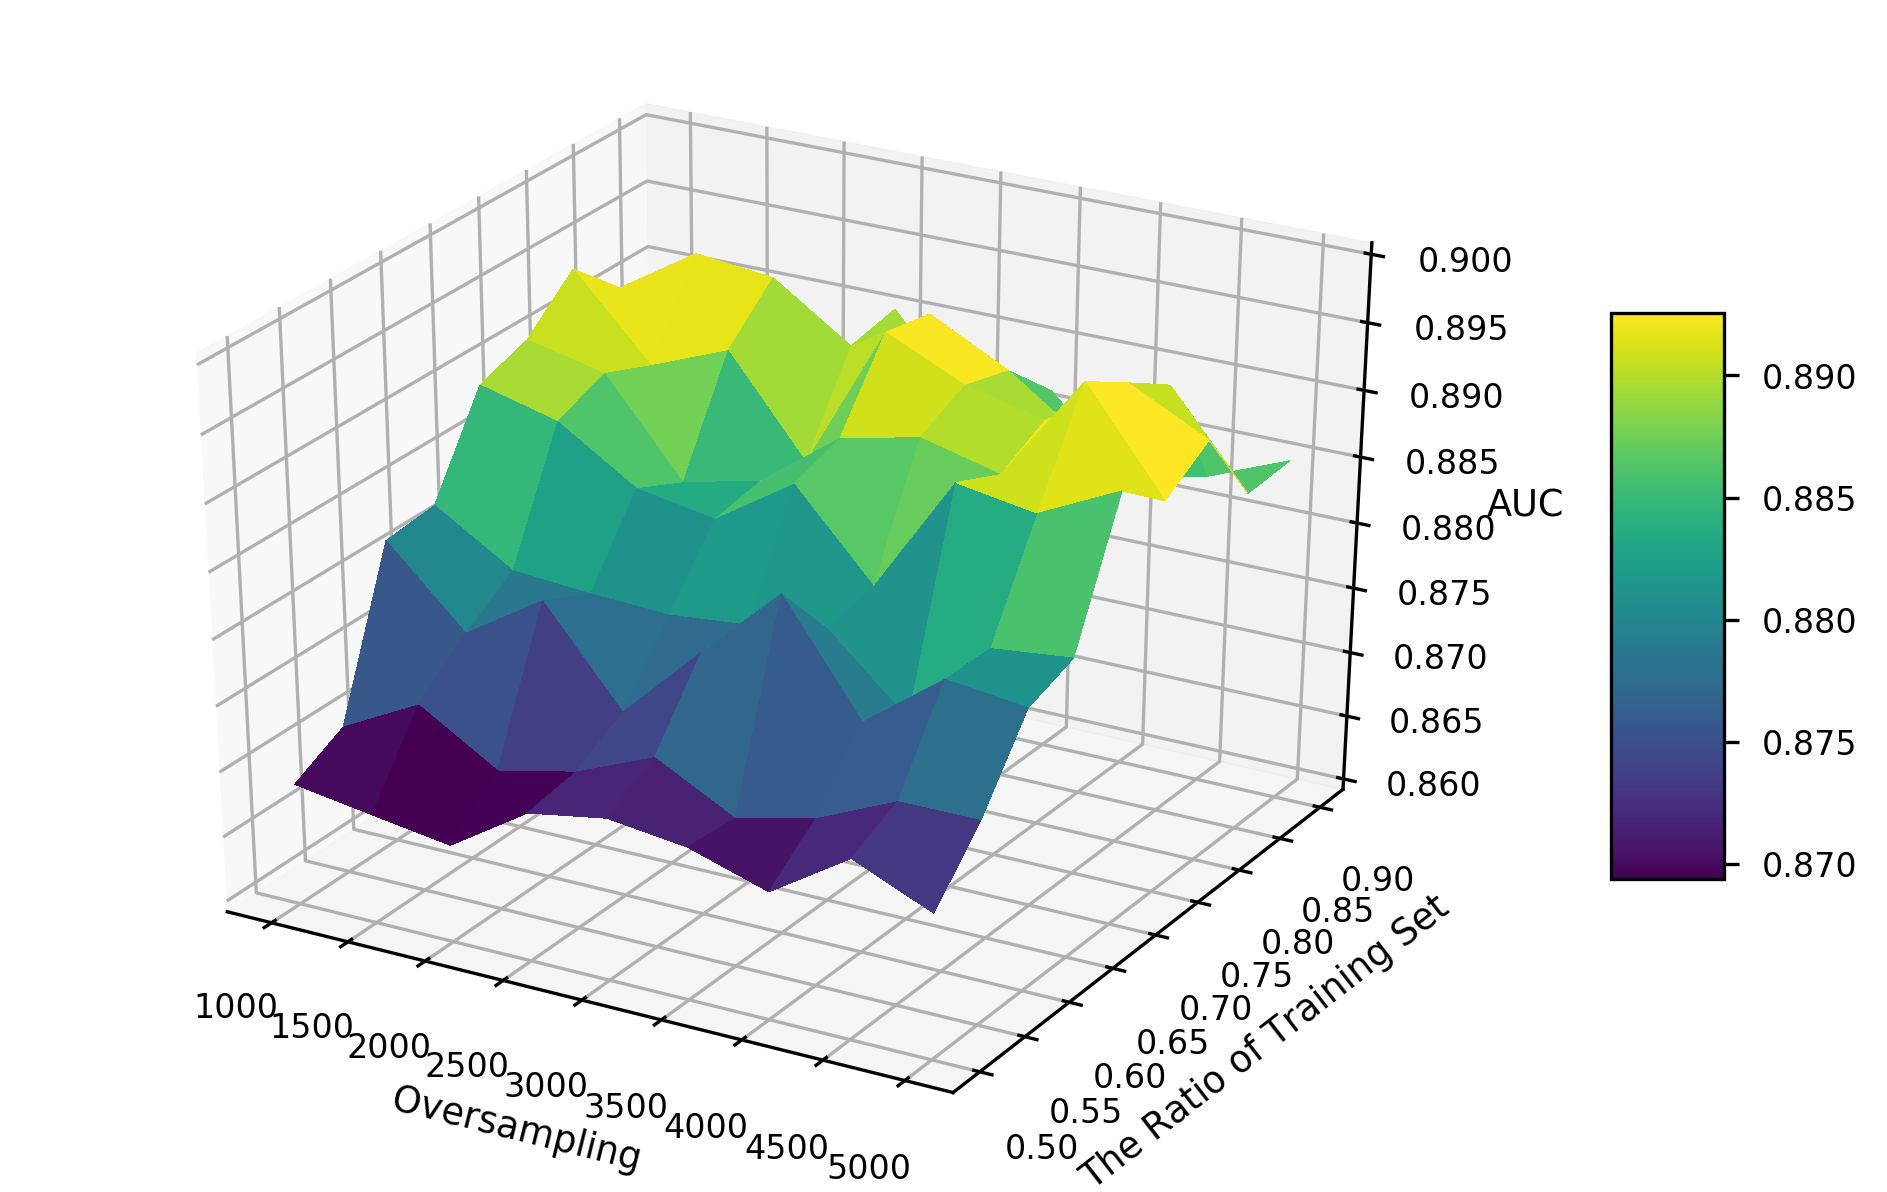

In [39]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.available
plt.style.use("seaborn-paper")

fig = plt.figure(1, (8, 5), dpi=300)
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(N, train_size, test_aucs, cmap='viridis', #cm.coolwarm
                       linewidth=0, antialiased=False)
_ = ax.set_zlim(0.86, 0.90)
_ = ax.set_xlabel('Oversampling')
_ = ax.set_ylabel('The Ratio of Training Set')
_ = ax.set_zlabel('AUC')
_ = fig.colorbar(surf, shrink=0.5, aspect=5)
_ = plt.show()

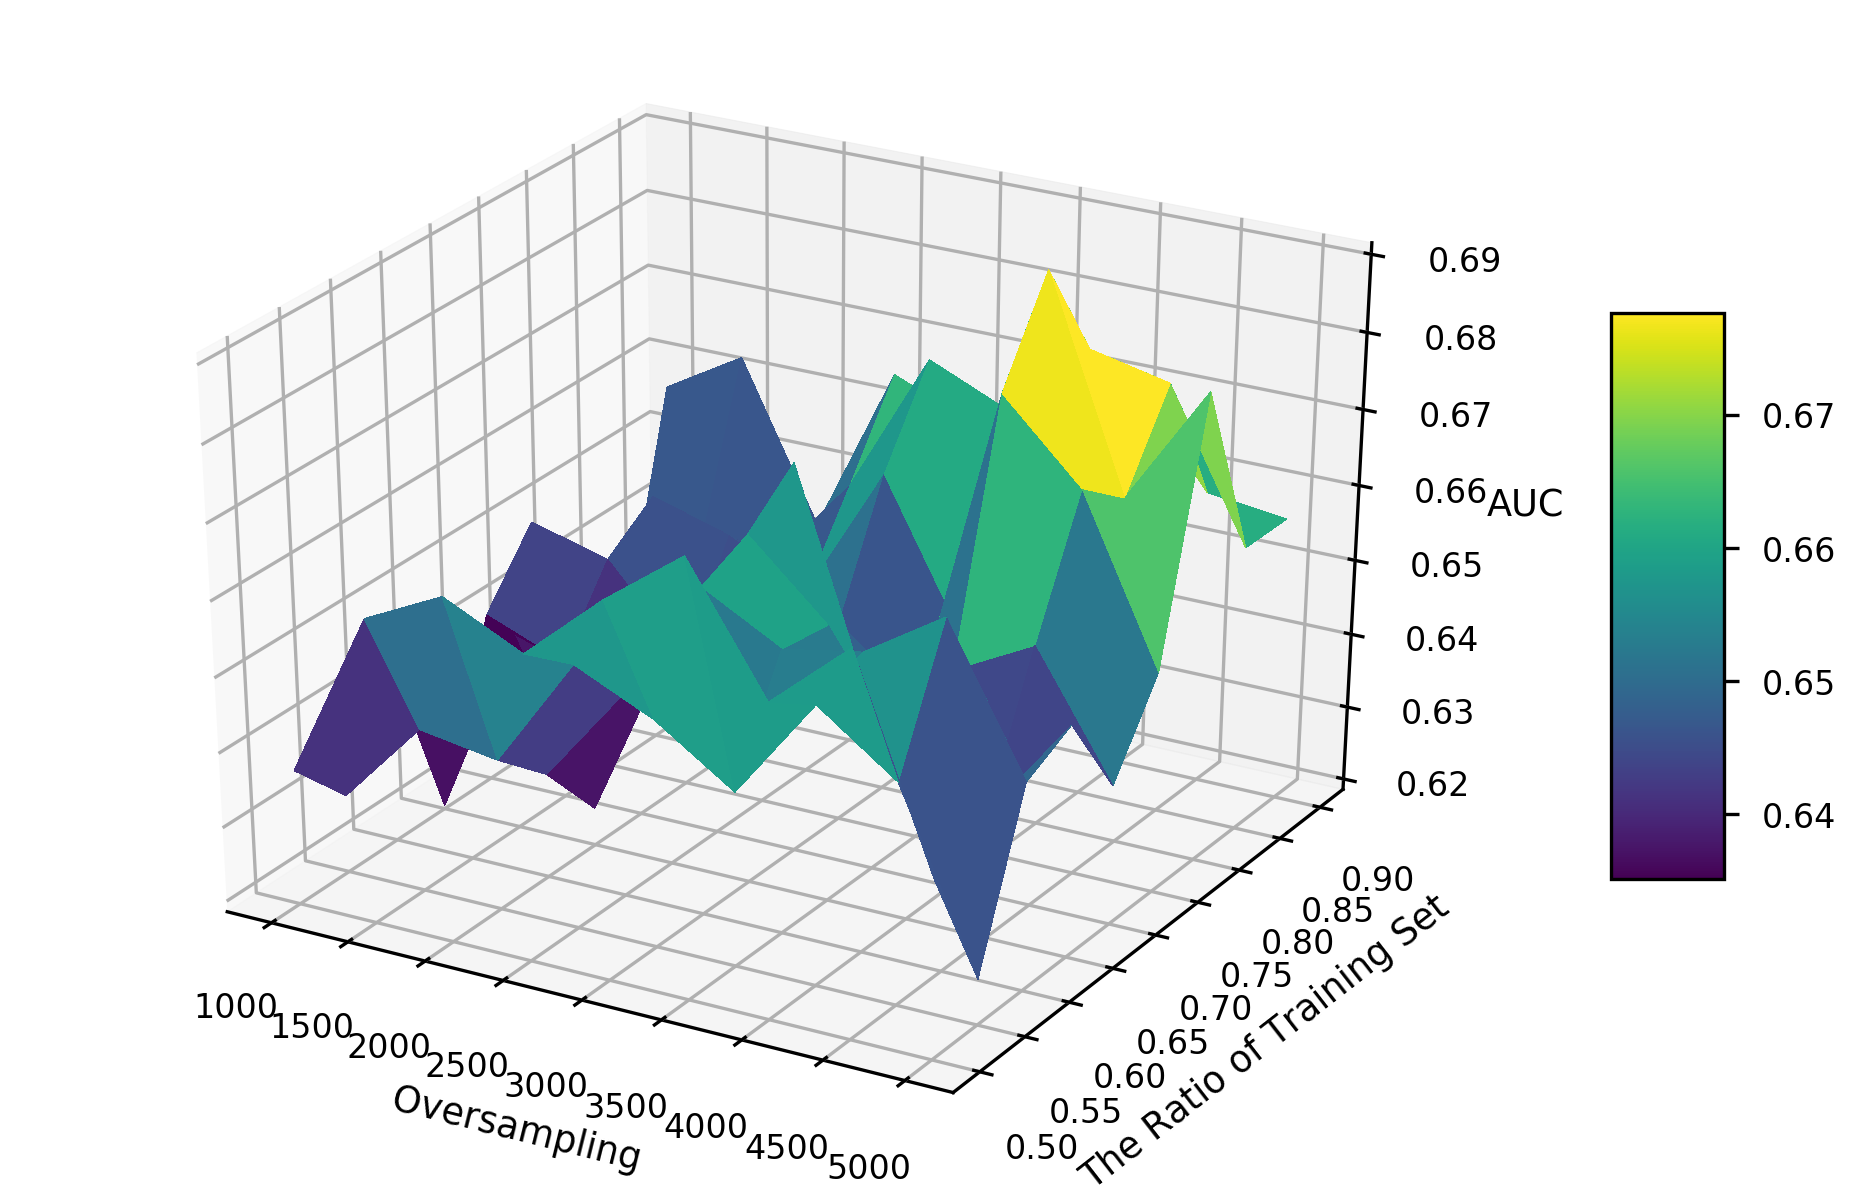

In [42]:
fig = plt.figure(1, (8, 5), dpi=300)
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(N, train_size, extend_aucs, cmap='viridis', #cm.coolwarm
                       linewidth=0, antialiased=False)
_ = ax.set_zlim(0.62, 0.69)
_ = ax.set_xlabel('Oversampling')
_ = ax.set_ylabel('The Ratio of Training Set')
_ = ax.set_zlabel('AUC')
_ = fig.colorbar(surf, shrink=0.5, aspect=5)
_ = plt.show()

# 6. Final model

In [43]:
def oversampling_raw(data, N=3000, sigma=0.1):
    # sampling
    sample_data = []
    sample_label = []
    sample_proteins = []
    proteins = np.array([i.split('_')[0] for i in data.index])
    for p in set(proteins):
        temp = data.loc[proteins==p, :]
        if N-sum(proteins==p)<=0:
            continue
        for i in range(N-sum(proteins==p)):
            rrow = list(temp.iloc[random.choice(range(len(temp.index))), :])
            sample_data.append(rrow)
            sample_label.append(int(rrow[-1]))
            sample_proteins.append(p)
    if len(sample_label) == 0:
        return data
    sample_data = pd.DataFrame(norm.rvs(np.array(sample_data), scale=sigma), columns=data.columns)
    sample_data.index = [sample_proteins[i]+'_OS_'+str(i) for i in range(len(sample_proteins))]
    sample_data[dep_var] = sample_label
    os_data = pd.DataFrame(data)
    os_data = os_data.append(sample_data)
    return os_data

In [44]:
result.sort_values('Extend AUC', ascending=False).head(2)
N = 4000
layern=5; celln=300; ps=0.5

,N,Train size,Test AUC,Extend AUC
56,4000,0.8,0.890084,0.691880
74,5000,0.8,0.891106,0.680653


In [46]:
data = data_raw.copy()
data = pd.concat([data_raw, data_extend], axis=0, sort=False)
data = oversampling_raw(data, N)

Valid_set = random.sample(list(data.index), 1000)
Valid_set = data.loc[Valid_set, :].copy()
Valid_set.index = ['Valid_'+i for i in Valid_set.index]
valid_idx = list(range(data.shape[0], data.shape[0]+Valid_set.shape[0]))
data = pd.concat([data, Valid_set], axis=0, sort=False)

In [48]:
procs = []
data_tabular = (TabularList.from_df(data, cat_names=[], cont_names=cont_names, procs=procs)
                       .split_by_idx(valid_idx=valid_idx)
                       .label_from_df(cols=dep_var)
                       .add_test(TabularList.from_df(data_extend, cat_names=[], cont_names=cont_names, procs=procs))
                       .databunch())
learn = tabular_learner(data_tabular, layers=[celln for i in range(layern)], metrics=accuracy, ps=ps, silent=False)
_ = learn.fit_one_cycle(50)
###
preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
_, pred_class = preds.max(1)
pred_prob = preds[:, 1]
roc_auc_score(data.iloc[valid_idx, :]['Activity'], pred_prob)
###
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
_, pred_class = preds.max(1)
pred_prob = preds[:, 1]
roc_auc_score(data_extend['Activity'], pred_prob)

epoch,train_loss,valid_loss,accuracy,time
0,0.640426,0.571328,0.693000,00:29
1,0.562757,0.517284,0.733000,00:25
2,0.508791,0.470116,0.743000,00:26
3,0.493670,0.425940,0.793000,00:26
4,0.451688,0.378927,0.816000,00:24
5,0.420573,0.328870,0.853000,00:25
6,0.405539,0.302714,0.881000,00:24
7,0.392584,0.310311,0.880000,00:24
8,0.377976,0.284148,0.864000,00:24
9,0.367183,0.266115,0.878000,00:24


0.9959637417986894

0.9958476799475324

In [50]:
pickle.dump([data, data_extend, valid_idx, cont_names, dep_var], 
            open('NR_DL_N4000_layer5_cell300_ps0.5.pkl', 'wb'))